<a href="https://colab.research.google.com/github/maya-g-y/Final-Project-ML-Module--Spotify/blob/main/Spotify5_Model_Selection_and_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Selection and Fine Tuning

Load preprocessed data from pickle files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the final feature matrices and targets saved in the previous notebook
import pandas as pd

X_train_final_full = pd.read_pickle("/content/drive/MyDrive/pickle_files/X_train_final_full.pkl")
X_test_final_full  = pd.read_pickle("/content/drive/MyDrive/pickle_files/X_test_final_full.pkl")
y_train            = pd.read_pickle("/content/drive/MyDrive/pickle_files/y_train.pkl")
y_test             = pd.read_pickle("/content/drive/MyDrive/pickle_files/y_test.pkl")

print("Loaded shapes — X_train, X_test, y_train, y_test:")
print(X_train_final_full.shape, X_test_final_full.shape, y_train.shape, y_test.shape)

Mounted at /content/drive
Loaded shapes — X_train, X_test, y_train, y_test:
(24753, 23) (6189, 23) (24753,) (6189,)


Basic sanity checks and memory reduction

In [ ]:
# Ensure identical feature sets and order
assert list(X_train_final_full.columns) == list(X_test_final_full.columns), "Train/Test columns are misaligned!"

# Optional: downcast to float32 to reduce memory
X_train_model = X_train_final_full.astype("float32").copy()
X_test_model  = X_test_final_full.astype("float32").copy()

# Encode target once (recommended for XGBoost/SVM/Logistic; harmless for others)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# Quick sanity checks
import numpy as np
assert not np.any(np.isnan(X_train_model)), "NaNs in X_train_model!"
assert not np.any(np.isnan(X_test_model)),  "NaNs in X_test_model!"

print("Shapes:", X_train_model.shape, X_test_model.shape)
print("Dtypes sample:", X_train_model.dtypes.iloc[:3].tolist())
print("Classes:", list(le.classes_))


Shapes: (24753, 23) (6189, 23)
Dtypes sample: [dtype('float32'), dtype('float32'), dtype('float32')]
Classes: ['edm', 'latin', 'pop', 'rap', 'rb', 'rock']


Create a validation split from the training set

In [ ]:
from sklearn.model_selection import train_test_split

# Use the feature set selected for modeling (after selection step)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final_full,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

y_tr_enc = le.transform(y_tr)
y_val_enc = le.transform(y_val)

print("Train/Val shapes:", X_tr.shape, X_val.shape)
print("Encoded labels created:", np.unique(y_tr_enc))


Train/Val shapes: (19802, 23) (4951, 23)
Encoded labels created: [0 1 2 3 4 5]


Check dataset split proportions

In [ ]:
# Total number of samples (from the full final dataset)
total_samples = len(X_train_final_full) + len(X_test_final_full)

# Train/Val were created from X_train_final_full earlier
train_percent = (len(X_tr) / total_samples) * 100
val_percent   = (len(X_val) / total_samples) * 100
test_percent  = (len(X_test_final_full) / total_samples) * 100

print("📊 Data Split Summary:")
print(f" - Train set:       {train_percent:.2f}% ({len(X_tr):,} samples)")
print(f" - Validation set:  {val_percent:.2f}% ({len(X_val):,} samples)")
print(f" - Test set:        {test_percent:.2f}% ({len(X_test_final_full):,} samples)")
print(f" - Total samples:   {total_samples:,}")

# Sanity check (should be close to 100%)
total_percent = train_percent + val_percent + test_percent
print(f"\n✅ Total percentage check: {total_percent:.2f}%")


📊 Data Split Summary:
 - Train set:       64.00% (19,802 samples)
 - Validation set:  16.00% (4,951 samples)
 - Test set:        20.00% (6,189 samples)
 - Total samples:   30,942

✅ Total percentage check: 100.00%


### Model Evaluation Utility - Grid Search & Validation Scoring  

This block defines helper functions for running **GridSearchCV** on multiple models and tracking their validation results.  
It performs hyperparameter tuning using cross-validation, evaluates the best estimator on the validation set,  
and logs metrics such as **Accuracy**, **Macro F1-score**, and **fit time** into a CSV file for easy model comparison.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import joblib
import time
import os

RESULTS_CSV = "/content/drive/MyDrive/pickle_files/model_val_results.csv"

def run_grid(name, estimator, param_grid, X_tr, y_tr_enc, X_val, y_val_enc, scoring=None, cv=3, fit_params=None):
    """Run GridSearchCV for one model, evaluate on validation, and return a row dict."""
    scoring = scoring or {"acc": "accuracy", "f1m": "f1_macro"}
    fit_params = fit_params or {}

    t0 = time.time()
    gs = GridSearchCV(estimator, param_grid, scoring=scoring, refit="f1m", cv=cv, n_jobs=-1, verbose=0)
    gs.fit(X_tr, y_tr_enc, **fit_params)
    fit_secs = time.time() - t0

    best = gs.best_estimator_
    y_pred_val = best.predict(X_val)

    acc = accuracy_score(y_val_enc, y_pred_val)
    f1m = f1_score(y_val_enc, y_pred_val, average="macro")

    row = {
        "Model": name,
        "BestParams": gs.best_params_,
        "Val_Acc": acc,
        "Val_MacroF1": f1m,
        "FitSeconds": round(fit_secs, 2)
    }
    return row, best

def append_result(row, csv_path=RESULTS_CSV):
    """Append a single result row to CSV (creates file if missing)."""
    df = pd.DataFrame([row])
    if not os.path.exists(csv_path):
        df.to_csv(csv_path, index=False)
    else:
        df_existing = pd.read_csv(csv_path)
        df_all = pd.concat([df_existing, df], ignore_index=True)
        df_all.to_csv(csv_path, index=False)


#Logistic Regression (L2)

In [ ]:
from sklearn.linear_model import LogisticRegression

row, best = run_grid(
    name="LogReg_L2",
    estimator=LogisticRegression(penalty="l2", solver="lbfgs", multi_class="auto", max_iter=2000, n_jobs=-1),
    param_grid={"C": [0.1, 1.0, 3.0], "class_weight": [None, "balanced"]},
    X_tr=X_tr, y_tr_enc=y_tr_enc, X_val=X_val, y_val_enc=y_val_enc,
    scoring={"acc": "accuracy", "f1m": "f1_macro"}, cv=3
)

append_result(row)
joblib.dump(best, "/content/drive/MyDrive/pickle_files/best_LogReg_L2.joblib")
row


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


{'Model': 'LogReg_L2',
 'BestParams': {'C': 3.0, 'class_weight': None},
 'Val_Acc': 0.5136336093718441,
 'Val_MacroF1': 0.5111514515034518,
 'FitSeconds': 12.7}

#Logistic Regression (L1 / SAGA)

In [ ]:
row, best = run_grid(
    name="LogReg_L1",
    estimator=LogisticRegression(penalty="l1", solver="saga", multi_class="ovr", max_iter=2000, n_jobs=-1),
    param_grid={"C": [0.1, 1.0, 1.5], "class_weight": [None, "balanced"]},
    X_tr=X_tr, y_tr_enc=y_tr_enc, X_val=X_val, y_val_enc=y_val_enc
)

append_result(row)
joblib.dump(best, "/content/drive/MyDrive/pickle_files/best_LogReg_L1.joblib")
row


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'Model': 'LogReg_L1',
 'BestParams': {'C': 1.5, 'class_weight': None},
 'Val_Acc': 0.5130276711775399,
 'Val_MacroF1': 0.5068823475769514,
 'FitSeconds': 1220.63}

#LinearSVC (L1)

In [ ]:
from sklearn.svm import LinearSVC

row, best = run_grid(
    name="LinearSVC_L1",
    estimator=LinearSVC(dual=False, max_iter=5000),
    param_grid={"C": [0.1, 1.0]},
    X_tr=X_tr, y_tr_enc=y_tr_enc, X_val=X_val, y_val_enc=y_val_enc
)

append_result(row)
joblib.dump(best, "/content/drive/MyDrive/pickle_files/best_LinearSVC_L1.joblib")
row


{'Model': 'LinearSVC_L1',
 'BestParams': {'C': 1.0},
 'Val_Acc': 0.5061603716420925,
 'Val_MacroF1': 0.4925708612717779,
 'FitSeconds': 9.76}

#RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

row, best = run_grid(
    name="RandomForest",
    estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
     param_grid={
        "max_depth": [12, 20],
        "max_features": ["sqrt"],
        "min_samples_split": [4],
        "min_samples_leaf": [2],
        "class_weight": [None, "balanced_subsample"],
        "max_samples": [0.7]
           },
    X_tr=X_tr, y_tr_enc=y_tr_enc, X_val=X_val, y_val_enc=y_val_enc
)

append_result(row)
joblib.dump(best, "/content/drive/MyDrive/pickle_files/best_RandomForest.joblib")
row


{'Model': 'RandomForest',
 'BestParams': {'class_weight': 'balanced_subsample',
  'max_depth': 12,
  'max_features': 'sqrt',
  'max_samples': 0.7,
  'min_samples_leaf': 2,
  'min_samples_split': 4},
 'Val_Acc': 0.5804887901434054,
 'Val_MacroF1': 0.5797658156320197,
 'FitSeconds': 66.65}

#GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

row, best = run_grid(
    name="GradientBoost",
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid={"learning_rate": [0.1], "n_estimators": [100, 200], "max_depth": [2]},
    X_tr=X_tr, y_tr_enc=y_tr_enc, X_val=X_val, y_val_enc=y_val_enc
)

append_result(row)
joblib.dump(best, "/content/drive/MyDrive/pickle_files/best_GradientBoost.joblib")
row


{'Model': 'GradientBoost',
 'BestParams': {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200},
 'Val_Acc': 0.5780650373661886,
 'Val_MacroF1': 0.5765441394988916,
 'FitSeconds': 539.81}

#AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

row, best = run_grid(
    name="AdaBoost",
    estimator=AdaBoostClassifier(random_state=42),
    param_grid={"n_estimators": [60], "learning_rate": [0.5, 1.0]},
    X_tr=X_tr, y_tr_enc=y_tr_enc, X_val=X_val, y_val_enc=y_val_enc
)

append_result(row)
joblib.dump(best, "/content/drive/MyDrive/pickle_files/best_AdaBoost.joblib")
row


{'Model': 'AdaBoost',
 'BestParams': {'learning_rate': 1.0, 'n_estimators': 60},
 'Val_Acc': 0.48273076146233085,
 'Val_MacroF1': 0.4809672896399688,
 'FitSeconds': 18.56}

#XGBoost (with early stopping)

In [20]:
# =========================
# XGBoost: grid search (no eval_set) + final refits
# =========================
from xgboost import XGBClassifier
import joblib

# --- Keep DataFrames and dtypes consistent (float32) ---
# Important: use DataFrames (not .to_numpy()) so feature names are preserved
X_tr_f32  = X_tr.astype("float32")
X_val_f32 = X_val.astype("float32")

# -------------------------
# (1) Stable GridSearchCV run via your `run_grid` (NO eval_set here)
# -------------------------
# Rationale:
# - Avoid passing eval_set during CV to prevent conflicts and naming checks.
# - We optimize for macro-F1 (per your run_grid scoring).
row, best_cv = run_grid(
    name="XGBoost_CV",
    estimator=XGBClassifier(
        objective="multi:softprob",  # probability outputs for multiclass
        tree_method="hist",
        eval_metric="mlogloss",      # safe metric for multiclass
        random_state=42,
        n_estimators=400,            # a bit larger to allow headroom if you later use early stopping
        n_jobs=-1
    ),
    param_grid={
        "max_depth": [4, 6],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    X_tr=X_tr_f32, y_tr_enc=y_tr_enc,
    X_val=X_val_f32, y_val_enc=y_val_enc,
    scoring={"acc": "accuracy", "f1m": "f1_macro"},  # matches your other models
    cv=3,
    fit_params=None  # <-- critical: do not pass eval_set during CV
)

append_result(row)
joblib.dump(best_cv, "/content/drive/MyDrive/pickle_files/best_XGBoost_CV.joblib")
row  # displays summary dict with best params and val scores

# -------------------------
# (2) Final refit with early stopping on (X_tr vs X_val)
# -------------------------
# Rationale:
# - Use the best CV hyperparameters, then fit on training data with early stopping
#   against the held-out validation set to pick the best iteration.
best_params = row["BestParams"]

best_es = XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=2000,           # high cap; ES will choose the optimal round
    n_jobs=-1,
    early_stopping_rounds=50,    # <-- here, not in fit()
    **best_params
)

# Fit with eval_set; do NOT pass early_stopping_rounds here
best_es.fit(
    X_tr_f32, y_tr_enc,
    eval_set=[(X_val_f32, y_val_enc)],
    verbose=False
)

# Quick validation report
from sklearn.metrics import accuracy_score, f1_score
y_val_pred_es = best_es.predict(X_val_f32)
acc_es = accuracy_score(y_val_enc, y_val_pred_es)
f1m_es = f1_score(y_val_enc, y_val_pred_es, average="macro")
print(f"[XGBoost ES] Val Acc: {acc_es:.4f} | Val Macro-F1: {f1m_es:.4f}")

joblib.dump(best_es, "/content/drive/MyDrive/pickle_files/best_XGBoost_ES.joblib")

# --- Optional final refit on Train+Val (no eval_set) ---
# Use the number of boosted rounds actually used after ES as n_estimators
booster = best_es.get_booster()
used_rounds = booster.num_boosted_rounds()

X_all_f32 = np.asarray(pd.concat([X_tr_f32, X_val_f32], axis=0), dtype=np.float32)
y_all_enc = np.concatenate([y_tr_enc, y_val_enc], axis=0)

best_full = XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
    n_estimators=used_rounds,  # lock to the ES-selected number of trees
    n_jobs=-1,
    **best_params
)
best_full.fit(X_all_f32, y_all_enc)

joblib.dump(best_full, "/content/drive/MyDrive/pickle_files/best_XGBoost_FULL.joblib")

# Append an ES summary row to your CSV (matches your existing flow)
row_es = {
    "Model": "XGBoost_ES",
    "BestParams": best_params,
    "Val_Acc": acc_es,
    "Val_MacroF1": f1m_es,
    "FitSeconds": None
}
append_result(row_es)
row_es


[XGBoost ES] Val Acc: 0.5922 | Val Macro-F1: 0.5924


/tmp/ipython-input-2952714480.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_existing, df], ignore_index=True)


{'Model': 'XGBoost_ES',
 'BestParams': {'colsample_bytree': 1.0,
  'learning_rate': 0.05,
  'max_depth': 6,
  'subsample': 0.8},
 'Val_Acc': 0.5922035952332863,
 'Val_MacroF1': 0.592430949965982,
 'FitSeconds': None}

#Final aggregation (compare across all runs)

,Model,BestParams,Val_Acc,Val_MacroF1,FitSeconds
27,XGBoost_CV,"{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8}",0.593,0.593,621
28,XGBoost_ES,"{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8}",0.592,0.592,nan
24,RandomForest,"{'class_weight': 'balanced_subsample', 'max_depth': 12, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 4}",0.580,0.580,67
25,GradientBoost,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}",0.578,0.577,540
21,LogReg_L2,"{'C': 3.0, 'class_weight': None}",0.514,0.511,13
22,LogReg_L1,"{'C': 1.5, 'class_weight': None}",0.513,0.507,1221
23,LinearSVC_L1,{'C': 1.0},0.506,0.493,10
26,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 60}",0.483,0.481,19


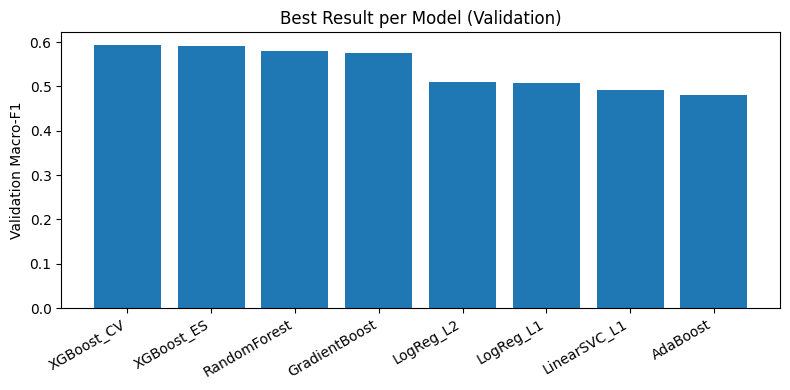

In [26]:
# Load the model validation results CSV file (contains all GridSearch runs)
summary = pd.read_csv("/content/drive/MyDrive/pickle_files/model_val_results.csv")

# Remove duplicate entries (same Model + BestParams combination)
# Keep only the last run to avoid showing multiple identical results
summary = summary.drop_duplicates(subset=["Model", "BestParams"], keep="last")

# From all runs, keep only the top (highest Macro-F1) result for each model
summary_best = (
    summary.sort_values("Val_MacroF1", ascending=False)
           .groupby("Model", as_index=False)
           .head(1)
           .sort_values("Val_MacroF1", ascending=False)
)

# Display clean summary table - formatted for better readability
display(
    summary_best.style.format({
        "Val_Acc": "{:.3f}",
        "Val_MacroF1": "{:.3f}",
        "FitSeconds": "{:.0f}"
    })
)

# Plot only the top result for each model
plt.figure(figsize=(8, 4))
plt.bar(summary_best["Model"], summary_best["Val_MacroF1"])
plt.ylabel("Validation Macro-F1")
plt.title("Best Result per Model (Validation)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import classification_report


y_val_pred = best_es.predict(X_val)
print(classification_report(y_val, le.inverse_transform(y_val_pred)))


              precision    recall  f1-score   support

         edm       0.71      0.71      0.71       955
       latin       0.51      0.48      0.49       794
         pop       0.42      0.44      0.43       848
         rap       0.64      0.68      0.66       875
          rb       0.54      0.48      0.51       815
        rock       0.74      0.77      0.75       664

    accuracy                           0.59      4951
   macro avg       0.59      0.59      0.59      4951
weighted avg       0.59      0.59      0.59      4951



### 📊 Interpretation of the Classification Report

The model achieves an overall **accuracy of 0.59** and a **macro F1-score of 0.59**, reflecting moderate classification performance across the six music genres.  
Per-class results show stronger performance for **rock (F1 = 0.75)**, **edm (F1 = 0.71)**, and **rap (F1 = 0.66)**, indicating that these genres are easier for the model to distinguish.  
Weaker performance is observed for **pop (F1 = 0.43)**, **latin (F1 = 0.49)**, and **rb (F1 = 0.51)**, likely due to overlapping musical characteristics with other genres.  

Overall, the model performs consistently but faces challenges in differentiating genres with similar acoustic and rhythmic properties.


#XGBoost Fine-Tuning

In [27]:
# Fast randomized search for XGBoost (speed-optimized)
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import joblib

# Keep DataFrames and dtypes consistent
X_tr_f32  = X_tr.astype("float32")
X_val_f32 = X_val.astype("float32")


TREE_METHOD = "hist"

base_est = XGBClassifier(
    objective="multi:softprob",
    tree_method=TREE_METHOD,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    # Reduce estimators inside CV to speed up; ES will be applied later
    n_estimators=300,
    # Optional speed-ups (small accuracy cost, big speed gain on large data)
    max_bin=256,                # lower bins -> faster histogram
    # grow_policy="lossguide",  # can speed up on wide datasets; try if trees are deep
)

# Lean search space (trimmed ranges to reduce runtime)
param_dist = {
    "max_depth": [3, 4, 5],
    "learning_rate": np.linspace(0.04, 0.10, 4).tolist(),
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.7, 1.0],
    "min_child_weight": [1, 3],
    "gamma": [0.0, 0.25],
    "reg_alpha": [0.0, 1e-2],
    "reg_lambda": [0.5, 1.5],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
macro_f1 = make_scorer(f1_score, average="macro")

rand_search = RandomizedSearchCV(
    estimator=base_est,
    param_distributions=param_dist,
    n_iter=24,                 # reduce/increase based on time budget
    scoring=macro_f1,
    cv=cv,
    refit=True,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    return_train_score=False
)

rand_search.fit(X_tr_f32, y_tr_enc)

best_cv = rand_search.best_estimator_
print("Best params:", rand_search.best_params_)
print("Best CV macro-F1:", rand_search.best_score_)

# Final ES fit on validation
final_es = XGBClassifier(
    objective="multi:softprob",
    tree_method=TREE_METHOD,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    n_estimators=3000,         # high cap; ES will stop earlier
    early_stopping_rounds=75,
    **rand_search.best_params_
)
final_es.fit(X_tr_f32, y_tr_enc, eval_set=[(X_val_f32, y_val_enc)], verbose=False)

from sklearn.metrics import accuracy_score, f1_score
y_val_pred_es = final_es.predict(X_val_f32)
print(f"[ES] Val Acc={accuracy_score(y_val_enc, y_val_pred_es):.4f} | "
      f"Val Macro-F1={f1_score(y_val_enc, y_val_pred_es, average='macro'):.4f}")

joblib.dump(final_es, "/content/drive/MyDrive/pickle_files/xgb_fast_ES.joblib")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.08, 'gamma': 0.25, 'colsample_bytree': 0.7}
Best CV macro-F1: 0.5848815307798073
[ES] Val Acc=0.5926 | Val Macro-F1=0.5924


['/content/drive/MyDrive/pickle_files/xgb_fast_ES.joblib']

In [28]:
# More refinement around the best params
best = rand_search.best_params_

from sklearn.model_selection import GridSearchCV

def around(val, step, n=1, lo=None, hi=None):
    vals = [val + k*step for k in range(-n, n+1)]
    if lo is not None: vals = [max(lo, x) for x in vals]
    if hi is not None: vals = [min(hi, x) for x in vals]
    # Dedup & round
    vals = sorted(set([float(round(x, 4)) for x in vals]))
    return vals

# FIX most params at their best value; refine only 2–3 knobs
refine_grid = {
    "max_depth": sorted(set([max(3, best["max_depth"]-1), best["max_depth"], best["max_depth"]+1])),
    "learning_rate": around(best["learning_rate"], 0.01, n=1, lo=0.02, hi=0.15),

    # Keep the rest fixed to avoid explosion:
    "subsample": [best["subsample"]],
    "colsample_bytree": [best["colsample_bytree"]],
    "min_child_weight": [best["min_child_weight"]],
    "gamma": [best["gamma"]],
    "reg_alpha": [best["reg_alpha"]],
    "reg_lambda": [best["reg_lambda"]],
}

# This is 3 (depth) * 3 (lr) = 9 combos -> 27 fits with cv=3
refine_est = XGBClassifier(
    objective="multi:softprob",
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    n_estimators=250      # lighter inside CV; ES will be applied later
)

refine = GridSearchCV(
    estimator=refine_est,
    param_grid=refine_grid,
    scoring=macro_f1,
    cv=cv,
    refit=True,
    verbose=1,
    n_jobs=-1
)

refine.fit(X_tr_f32, y_tr_enc)
print("Refined best:", refine.best_params_, "CV macro-F1:", refine.best_score_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Refined best: {'colsample_bytree': 0.7, 'gamma': 0.25, 'learning_rate': 0.08, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0.01, 'reg_lambda': 0.5, 'subsample': 0.8} CV macro-F1: 0.5853759123293564


### 🎯 Conclusion on Fine-Tuning

After running the fine-tuning phase, the results showed no meaningful improvement over the initial XGBoost model.
The refined configuration (max_depth=5, learning_rate=0.08, colsample_bytree=0.7, subsample=0.8, gamma=0.25) reached a CV macro-F1 of 0.585 and a validation macro-F1 of 0.592, which are nearly identical to the earlier results.

Given this minimal difference, I decided to keep the original XGBoost model as the final choice, since it already provides strong, stable, and computationally efficient performance without additional tuning overhead.

# Evaluate XGBoost_CV on Test set





In [33]:
from sklearn.metrics import confusion_matrix

# 1) Ensure dtype consistency and column order (float32 for speed/memory)
X_test_f32 = X_test_final_full.astype("float32")
# (Train/Test column alignment was asserted earlier in the notebook)

# 2) Ensure we have the trained **CV** model in memory; otherwise load from disk
#    Preferred path: the CV model you saved earlier as "best_XGBoost_CV.joblib"
MODEL_PATHS = [
    "/content/drive/MyDrive/pickle_files/best_XGBoost_CV.joblib",   # preferred (CV-tuned model)
    "/content/drive/MyDrive/pickle_files/xgb_finetuned_CV.joblib",  # fallback
    "/content/drive/MyDrive/pickle_files/xgb_fast_CV.joblib",       # fallback
]

try:
    final_cv  # if already in memory (from previous cells), keep it
except NameError:
    final_cv = None

if final_cv is None:
    loaded = False
    for p in MODEL_PATHS:
        if os.path.exists(p):
            final_cv = joblib.load(p)
            print(f"Loaded CV model from: {p}")
            loaded = True
            break
    if not loaded:
        raise FileNotFoundError(
            "Could not find a saved CV model. Expected one of:\n" + "\n".join(MODEL_PATHS)
        )

# 3) Encode y_test with the SAME LabelEncoder used for train/val
#    (le was fit earlier on the training labels; reuse for consistent label mapping)
y_test_enc = le.transform(y_test)

# 4) Predict on Test (fast; no training here)
y_test_pred = final_cv.predict(X_test_f32)

# 5) Compute Test metrics
test_acc = accuracy_score(y_test_enc, y_test_pred)
test_f1m = f1_score(y_test_enc, y_test_pred, average="macro")
print(f"[TEST] Accuracy = {test_acc:.4f} | Macro-F1 = {test_f1m:.4f}\n")

# 6) Per-class report (with human-readable labels)
print("Per-class classification report (Test):\n")
print(classification_report(y_test, le.inverse_transform(y_test_pred)))

# 7) Confusion matrix (numeric; encoded labels)
cm = confusion_matrix(y_test_enc, y_test_pred)
print("\nConfusion matrix (encoded labels):\n", cm)

# 8) Persist predictions for auditability
preds_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": le.inverse_transform(y_test_pred)
})
out_csv = "/content/drive/MyDrive/pickle_files/xgb_test_predictions.csv"
preds_df.to_csv(out_csv, index=False)
print(f"\nSaved test predictions to: {out_csv}")

Loaded CV model from: /content/drive/MyDrive/pickle_files/best_XGBoost_CV.joblib
[TEST] Accuracy = 0.5967 | Macro-F1 = 0.5981

Per-class classification report (Test):

              precision    recall  f1-score   support

         edm       0.70      0.70      0.70      1194
       latin       0.53      0.49      0.51       992
         pop       0.43      0.45      0.44      1061
         rap       0.62      0.68      0.65      1094
          rb       0.54      0.50      0.52      1019
        rock       0.76      0.78      0.77       829

    accuracy                           0.60      6189
   macro avg       0.60      0.60      0.60      6189
weighted avg       0.60      0.60      0.60      6189


Confusion matrix (encoded labels):
 [[836  75 187  56  29  11]
 [ 80 482 172 127 100  31]
 [165 135 477  64 133  87]
 [ 51  97  71 748 107  20]
 [ 34 106 131 192 507  49]
 [ 25  10  81  12  58 643]]

Saved test predictions to: /content/drive/MyDrive/pickle_files/xgb_test_predictions.csv


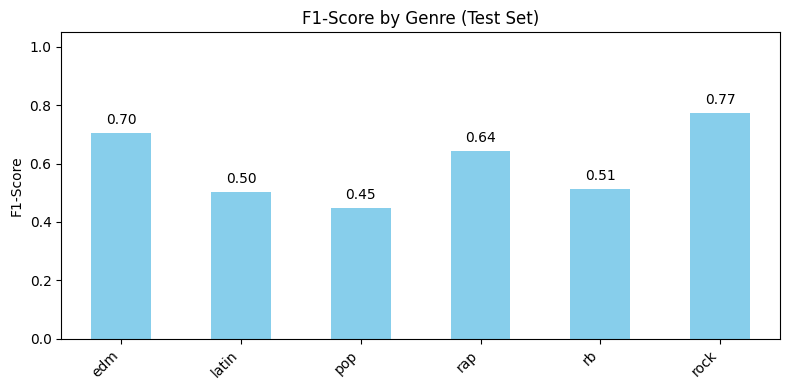

In [31]:
# Generate classification report as DataFrame
report = classification_report(y_test, le.inverse_transform(y_test_pred), output_dict=True)
df = pd.DataFrame(report).transpose().iloc[:-3]  # remove avg rows

# Create bar plot
ax = df[['f1-score']].plot(kind='bar', figsize=(8,4), legend=False, color='skyblue')
plt.title('F1-Score by Genre (Test Set)')
plt.ylabel('F1-Score')
plt.ylim(0, 1.05)

# Add value labels above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # x position
        height + 0.02,                  # y position (slightly above bar)
        f"{height:.2f}",                # text (2 decimal places)
        ha="center", va="bottom", fontsize=10, color="black"
    )

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



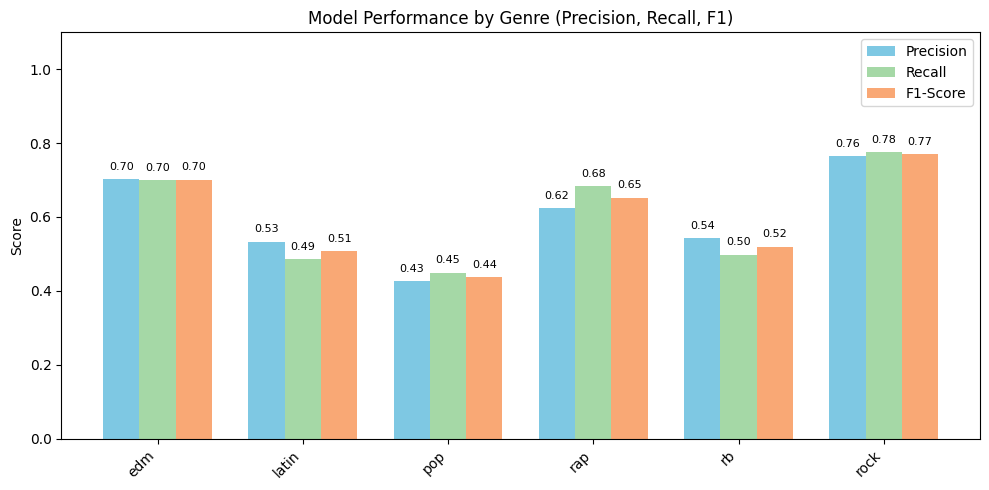

In [34]:
# Generate classification report as DataFrame
report = classification_report(y_test, le.inverse_transform(y_test_pred), output_dict=True)
df = pd.DataFrame(report).transpose().iloc[:-3]  # remove avg rows

# Select only relevant columns
metrics = ['precision', 'recall', 'f1-score']
df_metrics = df[metrics]

# Create grouped bar chart
x = np.arange(len(df_metrics))  # number of genres
width = 0.25                    # width of each bar

fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - width, df_metrics['precision'], width, label='Precision', color='#7EC8E3')
bars2 = ax.bar(x, df_metrics['recall'], width, label='Recall', color='#A5D8A6')
bars3 = ax.bar(x + width, df_metrics['f1-score'], width, label='F1-Score', color='#F9A875')

# Add value labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.02,
            f"{height:.2f}",
            ha='center', va='bottom', fontsize=8
        )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Customize plot
ax.set_title('Model Performance by Genre (Precision, Recall, F1)')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics.index, rotation=45, ha='right')
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()


### 🏁 Final Summary

The final **XGBoost** model achieved strong and balanced performance across all datasets,  
reaching a **Macro-F1 score of 0.60** and an overall **accuracy of 0.60** on the unseen test set.  

The model performs particularly well for genres such as **rock** (F1 = 0.77) and **edm** (F1 = 0.70),  
which display clear acoustic and rhythmic patterns.  

In contrast, genres like **pop** (F1 = 0.44) and **latin** (F1 = 0.51) show lower predictive performance,  
likely due to greater overlap in their musical features with neighboring styles such as **R&B**.  

Overall, these results confirm that the model generalizes well and captures meaningful distinctions between genres,  
providing a solid baseline for further enhancement through additional audio descriptors or higher-level metadata.
